### Set path to original pyNeuroChem. Please change to your own path

#### Import required libraries

In [1]:
import sys
#sys.path.append('/home/olexandr/notebooks/ASE_ANI/lib')
from ase_interface import ANIENS
from ase_interface import aniensloader
from ase_interface import ANIENS,ensemblemolecule

In [2]:
import numpy as np
import  ase
import time
#from ase.build import molecule
#from ase.neb import NEB
#from ase.calculators.mopac import MOPAC
from ase.md.langevin import Langevin
from ase.io.trajectory import Trajectory
from ase import units

from ase.optimize.fire import FIRE as QuasiNewton

from ase.md.nvtberendsen import NVTBerendsen
from ase.md.verlet import VelocityVerlet
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md import MDLogger

#from ase.neb import NEBtools
from ase.io import read, write
from ase.optimize import BFGS, LBFGS 

np.random.seed(0)
#0.0252235

#### Load the benzene molecule from the xyz

In [3]:
bz = read('/home/jujuman/Scratch/Research/UQ_MD_BASELINE/7h_mode5_sub_sc1.0.xyz')

#### Set ANI ensemble calculator

In [4]:
# Current ANI model options are:
# '../ani_models/ani-1ccx_8x.info' Coupled cluster transfer learned model
# '../ani_models/ani-1x_8x.info'   Full ANI-1x wb97x/6-31g* dataset model
bz.set_calculator(ANIENS(aniensloader('../ani_models/ani-1x_8x.info',1,multigpu=False)))

In [5]:
start_time = time.time()
dyn = LBFGS(bz)
dyn.run(fmax=0.001)
print('[ANI Total time:', time.time() - start_time, 'seconds]')

LBFGS:    1 21:10:40    -8931.251802        1.8294
LBFGS:    2 21:10:40    -8931.380481        1.1020
LBFGS:    3 21:10:40    -8931.408465        0.4702
LBFGS:    4 21:10:40    -8931.438847        0.5854
LBFGS:    5 21:10:40    -8931.454194        0.5728
LBFGS:    6 21:10:40    -8931.485953        0.4315
LBFGS:    7 21:10:40    -8931.512323        0.5727
LBFGS:    8 21:10:40    -8931.537819        0.4313
LBFGS:    9 21:10:40    -8931.558722        0.3966
LBFGS:   10 21:10:40    -8931.572938        0.3132
LBFGS:   11 21:10:40    -8931.585572        0.2721
LBFGS:   12 21:10:40    -8931.595713        0.2846
LBFGS:   13 21:10:41    -8931.605590        0.3260
LBFGS:   14 21:10:41    -8931.616480        0.2734
LBFGS:   15 21:10:41    -8931.628438        0.3285
LBFGS:   16 21:10:41    -8931.636979        0.2168
LBFGS:   17 21:10:41    -8931.642141        0.1391
LBFGS:   18 21:10:41    -8931.645638        0.1483
LBFGS:   19 21:10:41    -8931.649606        0.2085
LBFGS:   20 21:10:41    -8931.6

In [6]:
# Bias - parabola
# weight_f=100.0
# mult_const_f = 1.0
# const_f = 0.8

# weight_e=0.0
# mult_const_e = 1.0
# const_e = 0.14

# def bias_Efunc(sigma_f):
#     #print("sigma "+str(sigma))
#     return weight_f * (np.power((mult_const_f*sigma_f-const_f),2))

# # Force bias function
# def bias_Ffunc(sigma_f, dsigma):
#     #print(sigma_e)
#     return -weight_f *2*(mult_const_f*sigma_f-const_f)*mult_const_f* dsigma

# alpha = 1100
# beta = 200

# def bias_Efunc(x):
#     return alpha*np.exp(-beta*x*x)

# def bias_Ffunc(x,dx):
#     dy = alpha*beta*2*x*np.exp(-beta*x*x)*dx
#     return dy

# # Set the bias potential
# bz.calc.set_sigmabias(bias_Efunc, bias_Ffunc, epsilon=0.001, disable_ani=False)

# def bias_Efunc(x):
#     if x < 0.5:
#         y = alpha*np.exp(-beta*x)
#     else:
#         y = 0
#     return y

# def bias_Ffunc(x,dx):
#     if x < 0.5:
#         dy = -alpha*beta*np.exp(-beta*x)*dx
#     else:
#         dy = 0*dx
#     return dy


#Ealpha = -4.0
Ealpha = 0.4*0.0
Ebeta = 1
Egamma = 0.001

Falpha = 0.4*0.0
Fbeta = 1
Fgamma = 0.01

def bias_Efunc(Fx,Ex):
    #print(Ex,-Ealpha*np.log(Ebeta*(0.01+Ex)),Fx,-Falpha*np.log(Fbeta*(0.01+Fx)))
    return -Ealpha*np.log(Ebeta*(Egamma+Ex))-Falpha*np.log(Fbeta*(Fgamma+Fx))

def bias_Ffunc(Fx,Fdx,Ex,Edx):
    dy = Ealpha*Ebeta*(1.0/(Ebeta*(Egamma+Ex)))*Edx+Falpha*Fbeta*(1.0/(Fbeta*(Fgamma+Fx)))*Fdx
    return dy

#     def bias_Efunc(x):
#         return alpha*np.exp(-beta*x*x)

#     def bias_Ffunc(x,dx):
#         dy = alpha*beta*2*x*np.exp(-beta*x*x)*dx
#         return dy

# Set the bias potential
bz.calc.set_sigmabias(bias_Efunc, bias_Ffunc, epsilon=0.001, disable_ani=False)

In [7]:
Fn = bz.calc.calculate_numerical_forces(bz, d=0.001)

In [8]:
bz.get_potential_energy()
Fa = bz.get_forces()

In [9]:
np.mean(np.abs(Fn-Fa))

0.00016790597857288636

In [10]:
np.mean(np.sum(Fa,axis=0))

-2.6826306333302597e-07

In [11]:
np.mean(np.sum(Fn,axis=0))

0.0006580812623724341

In [12]:
import matplotlib.pyplot as plt

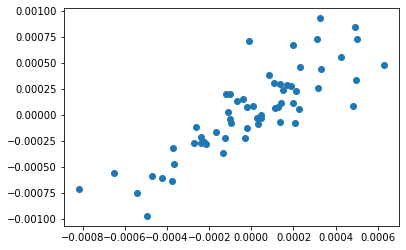

In [13]:
plt.scatter(Fa.flatten(),Fn.flatten())

#### Run Optimization

In [14]:
# Temperature
T = 300.0

# Time step
dt = 0.1

#MaxwellBoltzmannDistribution(bz, 300.0 * units.kB)

# We want to run MD with constant energy using the Langevin algorithm
# with a time step of 5 fs, the temperature T and the friction
# coefficient to 0.02 atomic units.
dyn = Langevin(bz, dt * units.fs, T * units.kB, 0.01)
#dyn = VelocityVerlet(bz, dt=0.5 * units.fs)

#### Setup printer function

In [15]:
Esigma = []
Fsigma = []

def printenergy(a=bz,b=dyn):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    
    Esig = a.calc.Estddev
    Fsig = a.calc.Fstddev
    
    Fbia = a.calc.nc.intermediates['Fbias']
    Fani = a.calc.nc.intermediates['Fele']
    
    E_v2 = a.calc.nc.intermediates['E_v2']
    F_v2 = a.calc.nc.intermediates['F_v2']
    
    avg_len_b = np.mean(np.linalg.norm(Fbia,axis=1))
    avg_len_n = np.mean(np.linalg.norm(Fani,axis=1))
    
    Esigma.append(Esig)
    Fsigma.append(Fsig)
    
    print('Step: %i Energy/atom: Ep=%.1feV  Ek=%.3feV (T=%3.0fK)  '
          'Et=%.1feV EV2=%.7f FV2=%.4f alb=%.3f aln=%.3f' % (dyn.get_number_of_steps(),epot, ekin, ekin / (1.5 * units.kB), epot + ekin, Esig, Fsig, avg_len_b, avg_len_n))
    
dyn.attach(printenergy, interval=25)
printenergy()

Step: 0 Energy/atom: Ep=-446.6eV  Ek=0.000eV (T=  0K)  Et=-446.6eV EV2=0.0048021 FV2=0.0760 alb=0.000 aln=0.000


#### Run 2000 steps of MD

In [16]:
start_time = time.time()
dyn.run(5000) # Do 1ps of MD    
print('[ANI Total time:', time.time() - start_time, 'seconds]')

Step: 25 Energy/atom: Ep=-446.6eV  Ek=0.000eV (T=  1K)  Et=-446.6eV EV2=0.0047566 FV2=0.0759 alb=0.000 aln=0.002
Step: 50 Energy/atom: Ep=-446.6eV  Ek=0.000eV (T=  2K)  Et=-446.6eV EV2=0.0045282 FV2=0.0756 alb=0.000 aln=0.003
Step: 75 Energy/atom: Ep=-446.6eV  Ek=0.000eV (T=  2K)  Et=-446.6eV EV2=0.0045368 FV2=0.0763 alb=0.000 aln=0.004
Step: 100 Energy/atom: Ep=-446.6eV  Ek=0.000eV (T=  3K)  Et=-446.6eV EV2=0.0046784 FV2=0.0768 alb=0.000 aln=0.003
Step: 125 Energy/atom: Ep=-446.6eV  Ek=0.000eV (T=  4K)  Et=-446.6eV EV2=0.0045936 FV2=0.0764 alb=0.000 aln=0.004
Step: 150 Energy/atom: Ep=-446.6eV  Ek=0.001eV (T=  4K)  Et=-446.6eV EV2=0.0045329 FV2=0.0763 alb=0.000 aln=0.005
Step: 175 Energy/atom: Ep=-446.6eV  Ek=0.001eV (T=  4K)  Et=-446.6eV EV2=0.0047597 FV2=0.0762 alb=0.000 aln=0.007
Step: 200 Energy/atom: Ep=-446.6eV  Ek=0.001eV (T=  6K)  Et=-446.6eV EV2=0.0050738 FV2=0.0771 alb=0.000 aln=0.006
Step: 225 Energy/atom: Ep=-446.6eV  Ek=0.001eV (T=  6K)  Et=-446.6eV EV2=0.0052604 FV2=0.07

Step: 1825 Energy/atom: Ep=-446.6eV  Ek=0.007eV (T= 54K)  Et=-446.6eV EV2=0.0047594 FV2=0.0747 alb=0.000 aln=0.020
Step: 1850 Energy/atom: Ep=-446.6eV  Ek=0.008eV (T= 59K)  Et=-446.6eV EV2=0.0034682 FV2=0.0778 alb=0.000 aln=0.014
Step: 1875 Energy/atom: Ep=-446.6eV  Ek=0.006eV (T= 48K)  Et=-446.6eV EV2=0.0044512 FV2=0.0772 alb=0.000 aln=0.022
Step: 1900 Energy/atom: Ep=-446.6eV  Ek=0.007eV (T= 54K)  Et=-446.6eV EV2=0.0040934 FV2=0.0790 alb=0.000 aln=0.020
Step: 1925 Energy/atom: Ep=-446.6eV  Ek=0.007eV (T= 53K)  Et=-446.6eV EV2=0.0050337 FV2=0.0777 alb=0.000 aln=0.023
Step: 1950 Energy/atom: Ep=-446.6eV  Ek=0.008eV (T= 61K)  Et=-446.6eV EV2=0.0058128 FV2=0.0785 alb=0.000 aln=0.020
Step: 1975 Energy/atom: Ep=-446.6eV  Ek=0.007eV (T= 55K)  Et=-446.6eV EV2=0.0065661 FV2=0.0762 alb=0.000 aln=0.020
Step: 2000 Energy/atom: Ep=-446.6eV  Ek=0.007eV (T= 57K)  Et=-446.6eV EV2=0.0063173 FV2=0.0762 alb=0.000 aln=0.019
Step: 2025 Energy/atom: Ep=-446.6eV  Ek=0.008eV (T= 60K)  Et=-446.6eV EV2=0.0058

Step: 3625 Energy/atom: Ep=-446.6eV  Ek=0.014eV (T=108K)  Et=-446.6eV EV2=0.0096515 FV2=0.0818 alb=0.000 aln=0.026
Step: 3650 Energy/atom: Ep=-446.6eV  Ek=0.015eV (T=119K)  Et=-446.6eV EV2=0.0089744 FV2=0.0797 alb=0.000 aln=0.026
Step: 3675 Energy/atom: Ep=-446.6eV  Ek=0.014eV (T=105K)  Et=-446.6eV EV2=0.0057827 FV2=0.0846 alb=0.000 aln=0.032
Step: 3700 Energy/atom: Ep=-446.6eV  Ek=0.014eV (T=105K)  Et=-446.6eV EV2=0.0067477 FV2=0.0765 alb=0.000 aln=0.031
Step: 3725 Energy/atom: Ep=-446.6eV  Ek=0.013eV (T= 99K)  Et=-446.6eV EV2=0.0093171 FV2=0.0857 alb=0.000 aln=0.032
Step: 3750 Energy/atom: Ep=-446.6eV  Ek=0.016eV (T=121K)  Et=-446.6eV EV2=0.0085711 FV2=0.0804 alb=0.000 aln=0.028
Step: 3775 Energy/atom: Ep=-446.6eV  Ek=0.014eV (T=108K)  Et=-446.6eV EV2=0.0053653 FV2=0.0817 alb=0.000 aln=0.030
Step: 3800 Energy/atom: Ep=-446.6eV  Ek=0.014eV (T=108K)  Et=-446.6eV EV2=0.0043651 FV2=0.0800 alb=0.000 aln=0.026
Step: 3825 Energy/atom: Ep=-446.6eV  Ek=0.014eV (T=106K)  Et=-446.6eV EV2=0.0062

In [ ]:
#np.save('Enobias.npy',np.array(Esigma))
#np.save('Fnobias.npy',np.array(Fsigma))

In [ ]:
Ev2nb = np.load('Enobias.npy')
Fv2nb = np.load('Fnobias.npy')

In [ ]:
Ev2bi = np.array(Esigma)
Fv2bi = np.array(Fsigma)

In [ ]:
Ev2nb.mean(),Ev2bi.mean()

In [ ]:
Fv2nb.mean(),Fv2bi.mean()

In [ ]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(7,7),dpi=300)
ax1.plot(25*np.arange(Ev2nb.size),Ev2nb,label='Normal MD')
ax1.plot(25*np.arange(Ev2bi.size),Ev2bi,'--',marker='o',label='UQ Biased MD')
#ax1.set_xlabel('MD Step')
ax1.set_ylabel('$V^2(E)$')
ax1.legend()

ax2.plot(25*np.arange(Fv2nb.size),Fv2nb,label='Normal MD')
ax2.plot(25*np.arange(Fv2bi.size),Fv2bi,'--',marker='o',label='UQ Biased MD')
ax2.set_xlabel('MD Step')
ax2.set_ylabel('$V^2(F)$')
ax2.legend()

plt.show()

In [ ]:
np.mean(v2nb),np.mean(v2bi)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
fig = plt.figure(figsize=(5,3),dpi=200)

# evenly sampled time at 200ms intervals
t = np.arange(-4., 4., 0.001)


def Efunc(x,alpha,beta):
    return -alpha*np.exp(-beta*x*x)

def Ffunc(x,alpha,beta):
    dy = alpha*beta*2*x*np.exp(-beta*x*x)
    return dy

# red dashes, blue squares and green triangles
plt.plot(t, Efunc(t,10,100000), 'r-')
plt.plot(t, Ffunc(t,10,100000), 'r-')

#plt.plot(t, Efunc(t,2,1), 'b-')
#plt.plot(t, Ffunc(t,2,1), 'b-')

#plt.plot(t, Efunc(t,1,1000), 'b-')
#plt.plot(t, Ffunc(t,1,1000), 'b-')

plt.show()

In [ ]:
fig = plt.figure(figsize=(5,3),dpi=200)

# evenly sampled time at 200ms intervals
t = np.arange(0, 4., 0.001)


def Efunc(x,alpha,beta):
    return alpha*np.exp(-beta*x)

def Ffunc(x,alpha,beta):
    dy = -alpha*beta*np.exp(-beta*x)
    return dy

# red dashes, blue squares and green triangles
plt.plot(t, Efunc(t,1,1), 'r-')
plt.plot(t, Ffunc(t,1,1), 'r-')

print(627*Efunc(0.0759942,0.5,1.0),627*Ffunc(0.0759942,0.5,1.0))

#plt.plot(t, Efunc(t,2,1), 'b-')
#plt.plot(t, Ffunc(t,2,1), 'b-')

#plt.plot(t, Efunc(t,1,1000), 'b-')
#plt.plot(t, Ffunc(t,1,1000), 'b-')

plt.show()

In [ ]:
fig = plt.figure(figsize=(5,3),dpi=200)

# evenly sampled time at 200ms intervals
t = np.arange(0.1, 4., 0.001)


def Efunc(x,alpha,beta):
    return -alpha*np.log(beta*x)

def Ffunc(x,alpha,beta):
    dy = alpha*beta*(1.0/(beta*x))
    return dy

# red dashes, blue squares and green triangles
plt.plot(t, Efunc(t,0.0001,1), 'r-')
#plt.plot(t, Efunc(t,1,10), 'g-')
plt.plot(t, Ffunc(t,0.0001,1), 'r-')

print(627*Efunc(0.0759942,0.5,1.0),627*Ffunc(0.0759942,0.5,1.0))

#plt.plot(t, Efunc(t,2,1), 'b-')
#plt.plot(t, Ffunc(t,2,1), 'b-')

#plt.plot(t, Efunc(t,1,1000), 'b-')
#plt.plot(t, Ffunc(t,1,1000), 'b-')

plt.show()

In [ ]:
np.array([1.0,2.0,3.0]).reshape(3,1,1)*np.array([[[1.0,1.0,1.0],[1.0,1.0,1.0]],[[1.0,1.0,1.0],[1.0,1.0,1.0]],[[1.0,1.0,1.0],[1.0,1.0,1.0]]])